<div class="alert alert-block alert-success">
    <font size="5"><b>Categorical Feature Encoding Challenge</b></font>
</div>

### Binary classification, with every feature a categorical

<img src="../img/header.png">

# Opis 

### Typowym zadaniem w potokach uczenia maszynowego jest kodowanie zmiennych kategorialnych dla danego algorytmu w formacie, który pozwala na przechwycenie jak największej liczby użytecznych sygnałów.

### Ponieważ jest to powszechny problem i ważna umiejętność do opanowania, przygotowaliśmy zestaw danych, który zawiera tylko cechy kategorialne i obejmuje:

### -  **binary features** - cechy binarne (bin_*)
### -  **low- and high-cardinality nominal features** - cechy nominalne o niskiej i wysokiej liczebności (nom_*)
### -  **low- and high-cardinality ordinal features** - cechy porządkowe o niskiej i wysokiej liczebności (ord_*), ciąg znaków porządkowych ord_ {3-5} jest uporządkowany leksykalnie według string.ascii_letters
### -  **(potentially) cyclical features** - potencjalnie cykliczne cechy opisujące dni tygodnia i miesiące.

# Ocena modelu

### Metryka: area under the ROC curve

# Zadanie

### W tej konkurencji będziesz przewidywał prawdopodobieństwo [0, 1] binarnej kolumny docelowej.
### Ponieważ celem tego konkursu jest zbadanie różnych strategii kodowania, dane zostały uproszczone, ponieważ nie ma brakujących wartości, oraz zestaw testowy nie zawiera żadnych niewidzialnych cech.

In [120]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

import string

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)  
%matplotlib inline

In [121]:
import category_encoders
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#from bayes_opt import BayesianOptimization
import eli5
#import shap
from IPython.display import HTML
import json
#import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product


In [122]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

   # for name in summary['Name'].value_counts().index:
    #    summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [123]:
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2


def reduce_memory_usage(df, deep=True, verbose=True, categories=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
   #     if verbose and best_type is not None and best_type != str(col_type):
    #        print(f"Column '{col}' converted from {col_type} to {best_type}")

    
    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
    
    
    return df

    

In [163]:
from numba import jit
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
 
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual'):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

# KFOLD

def train_model_classification_SKF(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual'):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict


In [125]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [126]:
%%time
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage decreased from 331.68MB to 316.51MB (15.16MB, 4.57% reduction)
Memory usage decreased from 219.59MB to 210.82MB (8.77MB, 4.00% reduction)
CPU times: user 11.2 s, sys: 122 ms, total: 11.3 s
Wall time: 8.8 s


# Małe co nieco o danych

In [127]:
resumetable(train)

Dataset Shape: (300000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,300000,0,1,2
1,bin_0,int8,0,2,0,0,0
2,bin_1,int8,0,2,0,1,0
3,bin_2,int8,0,2,0,0,0
4,bin_3,object,0,2,T,T,F
5,bin_4,object,0,2,Y,Y,Y
6,nom_0,object,0,3,Green,Green,Blue
7,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid
8,nom_2,object,0,6,Snake,Hamster,Lion
9,nom_3,object,0,6,Finland,Russia,Russia


In [128]:
resumetable(test)

Dataset Shape: (200000, 24)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,200000,300000,300001,300002
1,bin_0,int8,0,2,0,0,1
2,bin_1,int8,0,2,0,0,0
3,bin_2,int8,0,2,1,0,1
4,bin_3,object,0,2,T,T,F
5,bin_4,object,0,2,Y,N,Y
6,nom_0,object,0,3,Blue,Red,Blue
7,nom_1,object,0,6,Triangle,Square,Square
8,nom_2,object,0,6,Axolotl,Lion,Dog
9,nom_3,object,0,6,Finland,Canada,China


<div class="alert alert-block alert-success">
    <font size="5"><b>Teoria</b></font>
</div>

### **1. Cecha binarna / dychotomiczna - binary** to cecha badanej osoby, obiektu lub zjawiska, która przyjmuje jedynie dwie wartości. Najprostszym przykładem takiej zmiennej jest płeć, wynik badania: pozytywny lub negatywny.

### **2. Cechy jakościowe (niemierzalne) - nominal** to takie, których nie można jednoznacznie scharakteryzować za pomocą liczb (czyli nie można zmierzyć). Możemy je tylko opisać słowami. Możliwa jest zatem jedynie zupełna i rozłączna klasyfikacja zbioru wyników. Podstawową operacją pomiarową jest identyfikacja kategorii, do której należy zaliczyć wynik. Prowadzi to do podziału zbioru wyników na podzbiory rozłączne. Do cech jakościowych zaliczamy np. płeć, grupę krwi, kolor włosów, zgon lub przeżycie, stan uodpornienia przeciwko ospie (zaszczepiony lub nie) itp. W przypadku grupy krwi rezultat pomiaru będzie następujący: n1 pacjentów ma grupę krwi A, n2 pacjentów - grupę krwi B, n3 pacjentów - grupę AB i n4 - grupę O.

### **3. Cechy porządkowe - ordinal** umożliwiają porządkowanie (lub uszeregowanie) wszystkich elementów zbioru wyników. Cechy takie najlepiej określa się przymiotnikami i ich stopniowaniem. Każdemu ze stanów można również przypisać liczbę według wzrostu natężenia. Proces ten nazywa się rangowaniem. Na przykład, badając wzrost osoby, możemy użyć określeń: "niski", "średni" lub "wysoki". Podobnie, badając liczbę krwinek białych i używając określeń "poniżej normy", "w normie" lub "powyżej normy" - mamy do czynienia ze skalą porządkową. 

### Przykłady: 
### **a)** stopień zadowolenia - przyjmuje np. wartości z szeregu (nieszczęśliwy,niezadowolony,obojętny,zadowolony,szczęśliwy) jednakże nie można przyjąć, że różnica między nieszczęśliwym a niezadowolonym jest taka sama jak między obojętnym a zadowolonym
### **b)** wykształcenie - przyjmuje np. wartości z szeregu (brak,podstawowe,gimnazjalne,zasadnicze zawodowe,średnie,wyższe zawodowe,niepełne wyższe,wyższe) jednakże nie można przyjąć, że różnica między wyższym zawodowym a zasadniczym zawodowym jest taka sama jak np. zasadniczym zawodowym a podstawowym
### **c)** stadium choroby - przyjmuje np. wartości z szeregu (brak,stan początkowy,stan zaawansowany,stan terminalny) jednakże nie można przyjąć, że różnice pomiędzy kolejnymi stanami są jednakowe


### **3. Cechy ilościowe (mierzalne)** to takie, które dadzą się wyrazić za pomocą jednostek miary w pewnej skali. Cechami mierzalnymi są na przykład: wzrost (w cm), waga (w kg), stężenie hemoglobiny we krwi (w g/dl), wiek (w latach) itp. 

### Wśród cech mierzalnych wyróżniamy dwie podgrupy: cechy ciągłe i cechy skokowe:
### **a)** cecha ciągła to zmienna, która może przyjmować każdą wartość z określonego skończonego przedziału liczbowego, np. wzrost, masa ciała czy temperatura,
### **b)** cechy skokowe mogą przyjmować wartości ze zbioru skończonego lub przeliczalnego (zwykle całkowite), na przykład: liczba łóżek w szpitalu, liczba krwinek białych w 1 ml krwi. 

<div class="alert alert-block alert-success">
    <font size="5"><b>Features encoding</b></font>
</div>

In [130]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


# Binaryzacja

In [131]:
print ("Wartości w train przyjmowane przez bin_3", train['bin_3'].unique())
print ("Wartości w test przyjmowane przez bin_3", test['bin_3'].unique())

Wartości w train przyjmowane przez bin_3 ['T' 'F']
Wartości w test przyjmowane przez bin_3 ['T' 'F']


In [132]:
print ("Wartości w train przyjmowane przez bin_4", train['bin_4'].unique())
print ("Wartości w test przyjmowane przez bin_4", test['bin_4'].unique())

Wartości w train przyjmowane przez bin_4 ['Y' 'N']
Wartości w test przyjmowane przez bin_4 ['Y' 'N']


In [133]:
#Dictionary
binary_dict = {'T':1, 'F':0, 'Y':1, 'N':0}

# Maping
train['bin_3'] = train['bin_3'].map(binary_dict)
train['bin_4'] = train['bin_4'].map(binary_dict)
test['bin_3'] = test['bin_3'].map(binary_dict)
test['bin_4'] = test['bin_4'].map(binary_dict)

In [134]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [135]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,300000,0,0,1,1,1,Blue,Triangle,Axolotl,Finland,Piano,0870b0a5d,9ceb19dd6,530f8ecc3,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11
1,300001,0,0,0,1,0,Red,Square,Lion,Canada,Piano,a5c276589,1ad744242,12e6161c9,46ae3059c,285771075,1,Master,Lava Hot,l,A,RP,7,5
2,300002,1,0,1,0,1,Blue,Square,Dog,China,Piano,568550f04,1fe17a1fd,27d6df03f,b759e21f0,6f323c53f,2,Expert,Freezing,a,G,tP,1,12
3,300003,0,0,1,1,1,Red,Star,Cat,China,Piano,c5725677e,a6542cec0,30c63bd0c,0b6ec68ff,b5de3dcc4,1,Contributor,Lava Hot,b,Q,ke,2,3
4,300004,0,1,1,0,0,Red,Trapezoid,Dog,China,Piano,e70a6270d,97b6a3518,a42386065,f91f3b1ee,967cfa9c9,3,Grandmaster,Lava Hot,l,W,qK,4,11


# Nominal

## One Hot Encoding - nom_0 ... nom_4 - low cardinality

In [136]:
print (train['nom_0'].unique())
print (test['nom_0'].unique())

['Green' 'Blue' 'Red']
['Blue' 'Red' 'Green']


In [137]:
ohe_train = pd.get_dummies(train[['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']])
ohe_test = pd.get_dummies(test[['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']])

In [138]:
train = pd.concat([train, ohe_train], axis=1)
test = pd.concat([test, ohe_test], axis=1)

In [139]:
train.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1, inplace=True)
test.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1, inplace=True)

In [140]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0,0,0,1,1,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
1,1,0,1,0,1,1,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,2,0,0,0,0,1,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,3,0,1,0,0,1,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
4,4,0,0,0,0,0,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [141]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,300000,0,0,1,1,1,0870b0a5d,9ceb19dd6,530f8ecc3,9d117320c,3c49b42b8,2,Novice,Warm,j,P,be,5,11,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,300001,0,0,0,1,0,a5c276589,1ad744242,12e6161c9,46ae3059c,285771075,1,Master,Lava Hot,l,A,RP,7,5,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,300002,1,0,1,0,1,568550f04,1fe17a1fd,27d6df03f,b759e21f0,6f323c53f,2,Expert,Freezing,a,G,tP,1,12,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
3,300003,0,0,1,1,1,c5725677e,a6542cec0,30c63bd0c,0b6ec68ff,b5de3dcc4,1,Contributor,Lava Hot,b,Q,ke,2,3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,300004,0,1,1,0,0,e70a6270d,97b6a3518,a42386065,f91f3b1ee,967cfa9c9,3,Grandmaster,Lava Hot,l,W,qK,4,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0


## LabelEncoder - nom_5 ... nom_9 - high cardinality

In [142]:
for f in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f'label_enc_{f}'] = lbl.transform(list(train[f].values))
        test[f'label_enc_{f}'] = lbl.transform(list(test[f].values))   

In [143]:
train.drop(['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis=1, inplace=True)
test.drop(['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis=1, inplace=True)

In [144]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9
0,0,0,0,0,1,1,2,Grandmaster,Cold,h,D,kr,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,78,120,491,1689,2192
1,1,0,1,0,1,1,1,Grandmaster,Hot,a,A,bF,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,159,510,260,652,11719
2,2,0,0,0,0,1,1,Expert,Lava Hot,h,R,Jc,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,44,14,766,1935,8140
3,3,0,1,0,0,1,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,209,165,1121,631,6098
4,4,0,0,0,0,0,1,Grandmaster,Freezing,a,R,qP,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,90,61,34,1763,8293


In [145]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9
0,300000,0,0,1,1,1,2,Novice,Warm,j,P,be,5,11,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,8,320,372,1370,2836
1,300001,0,0,0,1,0,1,Master,Lava Hot,l,A,RP,7,5,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,151,53,79,597,1906
2,300002,1,0,1,0,1,2,Expert,Freezing,a,G,tP,1,12,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,84,61,164,1574,5214
3,300003,0,0,1,1,1,1,Contributor,Lava Hot,b,Q,ke,2,3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,173,334,199,107,8521
4,300004,0,1,1,0,0,3,Grandmaster,Lava Hot,l,W,qK,4,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,197,305,752,2160,7027


# Ordinals

## Low cardinality ord_1.. ord_4

In [146]:
print (train['ord_1'].unique())

print (test['ord_1'].unique())

['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
['Novice' 'Master' 'Expert' 'Contributor' 'Grandmaster']


In [147]:
# Importing categorical options of pandas
from pandas.api.types import CategoricalDtype 

# seting the orders of our ordinal features
ord_1 = CategoricalDtype(categories=['Novice', 'Contributor','Expert', 
                                     'Master', 'Grandmaster'], ordered=True)
ord_2 = CategoricalDtype(categories=['Freezing', 'Cold', 'Warm', 'Hot',
                                     'Boiling Hot', 'Lava Hot'], ordered=True)
ord_3 = CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e', 'f', 'g',
                                     'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'], ordered=True)
ord_4 = CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                                     'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                                     'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ordered=True)

In [148]:
# Transforming ordinal Features
train.ord_1 = train.ord_1.astype(ord_1).cat.codes
train.ord_2 = train.ord_2.astype(ord_2).cat.codes
train.ord_3 = train.ord_3.astype(ord_3).cat.codes
train.ord_4 = train.ord_4.astype(ord_4).cat.codes

# test dataset
test.ord_1 = test.ord_1.astype(ord_1).cat.codes
test.ord_2 = test.ord_2.astype(ord_2).cat.codes
test.ord_3 = test.ord_3.astype(ord_3).cat.codes
test.ord_4 = test.ord_4.astype(ord_4).cat.codes

In [149]:
test.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9
0,300000,0,0,1,1,1,2,0,2,9,15,be,5,11,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,8,320,372,1370,2836
1,300001,0,0,0,1,0,1,3,5,11,0,RP,7,5,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,151,53,79,597,1906
2,300002,1,0,1,0,1,2,2,0,0,6,tP,1,12,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,84,61,164,1574,5214
3,300003,0,0,1,1,1,1,1,5,1,16,ke,2,3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,173,334,199,107,8521
4,300004,0,1,1,0,0,3,4,5,11,22,qK,4,11,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,197,305,752,2160,7027


In [150]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9
0,0,0,0,0,1,1,2,4,1,7,3,kr,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,78,120,491,1689,2192
1,1,0,1,0,1,1,1,4,3,0,0,bF,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,159,510,260,652,11719
2,2,0,0,0,0,1,1,2,5,7,17,Jc,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,44,14,766,1935,8140
3,3,0,1,0,0,1,1,4,4,8,3,kW,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,209,165,1121,631,6098
4,4,0,0,0,0,0,1,4,0,0,17,qP,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,90,61,34,1763,8293


In [151]:
resumetable(train)

Dataset Shape: (300000, 45)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,300000,0,1,2
1,bin_0,int8,0,2,0,0,0
2,bin_1,int8,0,2,0,1,0
3,bin_2,int8,0,2,0,0,0
4,bin_3,int64,0,2,1,1,0
5,bin_4,int64,0,2,1,1,1
6,ord_0,int8,0,3,2,1,1
7,ord_1,int8,0,5,4,4,2
8,ord_2,int8,0,6,1,3,5
9,ord_3,int8,0,15,7,0,7


In [152]:
resumetable(test)

Dataset Shape: (200000, 44)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,200000,300000,300001,300002
1,bin_0,int8,0,2,0,0,1
2,bin_1,int8,0,2,0,0,0
3,bin_2,int8,0,2,1,0,1
4,bin_3,int64,0,2,1,1,0
5,bin_4,int64,0,2,1,0,1
6,ord_0,int8,0,3,2,1,2
7,ord_1,int8,0,5,0,3,2
8,ord_2,int8,0,6,2,5,0
9,ord_3,int8,0,15,9,11,0


# ORD_5

In [153]:
#Split 'ord_5' into two new columns using the indices of two letters in string.ascii_letters, separately'''
train['ord_5_oe1'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
test['ord_5_oe1'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))

train['ord_5_oe2'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
test['ord_5_oe2'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))


In [154]:
train.drop(['ord_5'], axis=1, inplace=True)
test.drop(['ord_5'], axis=1, inplace=True)

In [155]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,day,month,target,nom_0_Blue,nom_0_Green,nom_0_Red,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_Canada,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Bassoon,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9,ord_5_oe1,ord_5_oe2
0,0,0,0,0,1,1,2,4,1,7,3,2,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,78,120,491,1689,2192,11,18
1,1,0,1,0,1,1,1,4,3,0,0,7,8,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,159,510,260,652,11719,2,32
2,2,0,0,0,0,1,1,2,5,7,17,7,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,44,14,766,1935,8140,36,3
3,3,0,1,0,0,1,1,4,4,8,3,2,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,209,165,1121,631,6098,11,49
4,4,0,0,0,0,0,1,4,0,0,17,7,8,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,90,61,34,1763,8293,17,42


In [156]:
resumetable(train)

Dataset Shape: (300000, 46)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,300000,0,1,2
1,bin_0,int8,0,2,0,0,0
2,bin_1,int8,0,2,0,1,0
3,bin_2,int8,0,2,0,0,0
4,bin_3,int64,0,2,1,1,0
5,bin_4,int64,0,2,1,1,1
6,ord_0,int8,0,3,2,1,1
7,ord_1,int8,0,5,4,4,2
8,ord_2,int8,0,6,1,3,5
9,ord_3,int8,0,15,7,0,7


# Cyclical

In [158]:
resumetable(train)

Dataset Shape: (300000, 50)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id,int32,0,300000,0.000000000000000,1.000000000000000e+00,2.000000000000000e+00
1,bin_0,int8,0,2,0.000000000000000,0.000000000000000e+00,0.000000000000000e+00
2,bin_1,int8,0,2,0.000000000000000,1.000000000000000e+00,0.000000000000000e+00
3,bin_2,int8,0,2,0.000000000000000,0.000000000000000e+00,0.000000000000000e+00
4,bin_3,int64,0,2,1.000000000000000,1.000000000000000e+00,0.000000000000000e+00
5,bin_4,int64,0,2,1.000000000000000,1.000000000000000e+00,1.000000000000000e+00
6,ord_0,int8,0,3,2.000000000000000,1.000000000000000e+00,1.000000000000000e+00
7,ord_1,int8,0,5,4.000000000000000,4.000000000000000e+00,2.000000000000000e+00
8,ord_2,int8,0,6,1.000000000000000,3.000000000000000e+00,5.000000000000000e+00
9,ord_3,int8,0,15,7.000000000000000,0.000000000000000e+00,7.000000000000000e+00


In [159]:
X = train.drop(['target', 'id'], axis=1)

y = train['target']

y=y.astype('int')

X_test = test.drop(['id'], axis=1)

In [160]:
gc.collect()

127

# LGBM v1  KFold

In [161]:
n_fold = 7
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=7, random_state=1, shuffle=True)

Fold 1 started at Wed Oct 16 18:03:58 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.821842	training's auc: 0.821842	valid_1's auc: 0.774351	valid_1's auc: 0.774351
[1000]	training's auc: 0.857979	training's auc: 0.857979	valid_1's auc: 0.775253	valid_1's auc: 0.775253
Early stopping, best iteration is:
[857]	training's auc: 0.848695	training's auc: 0.848695	valid_1's auc: 0.775415	valid_1's auc: 0.775415
Fold 2 started at Wed Oct 16 18:06:53 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.822047	training's auc: 0.822047	valid_1's auc: 0.772529	valid_1's auc: 0.772529
[1000]	training's auc: 0.858027	training's auc: 0.858027	valid_1's auc: 0.774243	valid_1's auc: 0.774243
[1500]	training's auc: 0.886003	training's auc: 0.886003	valid_1's auc: 0.77418	valid_1's auc: 0.77418
Early stopping, best iteration is:
[1324]	training's auc: 0.876906	training's auc: 0.876906	valid_1's auc: 0.774404	valid_1's au

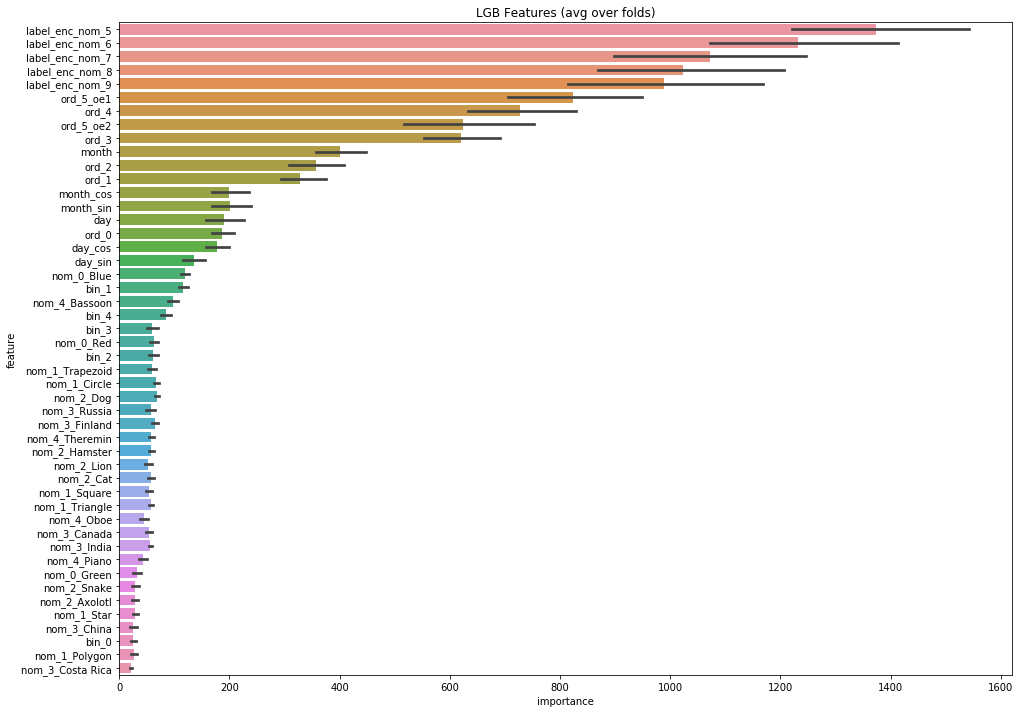

In [164]:
params = {'num_leaves': 80,
          'min_child_samples': 40,
          'objective': 'binary',
          'max_depth': 30,
          'learning_rate': 0.036435924231038266,
          "boosting_type": "gbdt",
          "subsample_freq": 4,
          "subsample": 0.9481868079865589,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3961060691697725,
         'reg_lambda': 0.47650162280060226, 
         # 'colsample_bytree': 0.5016882736572621,
         # 'feature_fraction': 0.30387207575823505,
          
         }
result_dict_lgb = train_model_classification(X=X, 
                                             X_test=X_test, 
                                             y=y, 
                                             params=params, 
                                             folds=folds,
                                             model_type='lgb',
                                             #model_type='xgb',
                                             eval_metric='auc', 
                                             plot_feature_importance=True,
                                             verbose=500, 
                                             early_stopping_rounds=500, 
                                             n_estimators=7500, 
                                             averaging='usual')

In [165]:
test = test.sort_values('id')
test['target'] = result_dict_lgb['prediction']
sub = pd.read_csv('../sub_sample/sample_submission.csv')
sub['target'] = test['target']
sub.to_csv('../sub/DWRZ-16-v01-lgbm-shuffle-false.csv', index=False)
sub.head()

,id,target
0,300000,0.307070328144386
1,300001,0.655681578414656
2,300002,0.203197034183898
3,300003,0.372465386183636
4,300004,0.748948364705070


#### LGBM v1 - wynik na kaggle około 0.77922

# LGBM v2  StratifiedKFold

In [166]:
n_fold = 7
folds = TimeSeriesSplit(n_splits=n_fold)
folds = StratifiedKFold(n_splits=7, random_state=1, shuffle=True)

Fold 1 started at Wed Oct 16 18:34:32 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.794753	training's auc: 0.794753	valid_1's auc: 0.771294	valid_1's auc: 0.771294
[1000]	training's auc: 0.816226	training's auc: 0.816226	valid_1's auc: 0.77479	valid_1's auc: 0.77479
[1500]	training's auc: 0.83331	training's auc: 0.83331	valid_1's auc: 0.775307	valid_1's auc: 0.775307
[2000]	training's auc: 0.848378	training's auc: 0.848378	valid_1's auc: 0.775778	valid_1's auc: 0.775778
Early stopping, best iteration is:
[1838]	training's auc: 0.843797	training's auc: 0.843797	valid_1's auc: 0.775849	valid_1's auc: 0.775849
Fold 2 started at Wed Oct 16 18:39:22 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.795011	training's auc: 0.795011	valid_1's auc: 0.769836	valid_1's auc: 0.769836
[1000]	training's auc: 0.816371	training's auc: 0.816371	valid_1's auc: 0.774211	valid_1's auc: 0.774211
[1500]	training's auc: 0

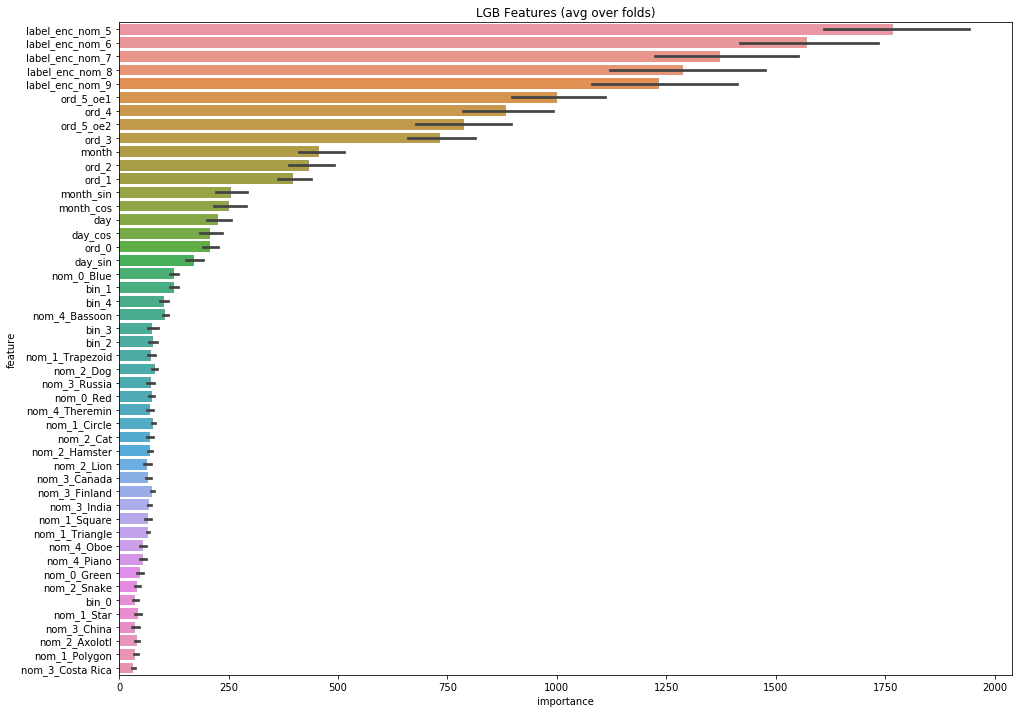

In [168]:
params = {'num_leaves': 48,
          'min_child_samples': 30,
          'objective': 'binary',
          'max_depth': 76,
          'learning_rate': 0.026435924231038266,
          "boosting_type": "gbdt",
          "subsample_freq": 4,
          "subsample": 0.9481868079865589,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
         'reg_alpha': 0.3961060691697725,
        'reg_lambda': 0.47650162280060226, 
         # 'colsample_bytree': 0.5016882736572621,
         # 'feature_fraction': 0.30387207575823505,
          }

result_dict_lgb = train_model_classification_SKF(X=X, 
                                                 X_test=X_test, 
                                                 y=y, 
                                                 params=params, 
                                                 folds=folds,
                                                 model_type='lgb',
                                                 #model_type='xgb',
                                                 eval_metric='auc', 
                                                 plot_feature_importance=True,
                                                 verbose=500, 
                                                 early_stopping_rounds=500, 
                                                 n_estimators=8500, 
                                                 averaging='usual')

In [171]:
test = test.sort_values('id')
test['target'] = result_dict_lgb['prediction']
sub = pd.read_csv('../sub_sample/sample_submission.csv')
sub['target'] = test['target']
sub.to_csv('../sub/DWRZ-16-v02-SKF-shuffle-True.csv', index=False)
sub.head()

,id,target
0,300000,0.329244273766231
1,300001,0.668717722877986
2,300002,0.212571259611633
3,300003,0.389918837099325
4,300004,0.757067838079466


#### LGBM v2 - wynik na kaggle około 0.78033

<div class="alert alert-block alert-success">
    <font size="5"><b>Advanced Categorical encoding.</b></font>
</div>


#### Istnieje wiele sposobów kodowania kategorycznego.
#### Mamy między innmi bibliotekę Categor Encoders, w której zaimplementowano wiele koderów: http://contrib.scikit-learn.org/categorical-encoding/index.html



## Scikit-learn-style transformers

- Backward Difference Coding
- BaseN
- Binary
- CatBoost Encoder
- Hashing
- Helmert Coding
- James-Stein Encoder
- Leave One Out
- M-estimate
- One Hot
- Ordinal
- Polynomial Coding
- Sum Coding
- Target Encoder
- Weight of Evidence


<div class="alert alert-block alert-success">
    <font size="5"><b> Walidacja modelu jest prawdopodobnie najważniejszym aspektem uczenia maszynowego. Pracując z danymi zawierającymi zmienne jakościowe, możemy chcieć użyć jednego z trzech rodzajów sprawdzania poprawności. 
        <br> * Brak Walidacji jest najprostszy, ale najmniej dokładny pod względem wyników.
<br>* Podwójna walidacja może pokazać świetne wyniki, ale jest bardzo wolna. <br> * Pojedyncza validacja to swego rodzaju skrzyżowanie dwóch pierwszych metod.</b></font>
</div>


# Brak walidacji

<img src="../img/no_validation.png">

#### W przypadku braku sprawdzania poprawności pojedynczy enkoder jest dopasowywany do wszystkich danych. Sprawdzanie poprawności i części testowe zestawu danych są przetwarzane za pomocą tego samego pojedynczego kodera. Jest to najprostsze podejście, szeroko stosowane, ale prowadzi do nadmiernego dopasowania podczas treningu i niewiarygodnych wyników walidacji. 
#### Model nie wie, jak obsługiwać nowe kategorie.


# Pojedyncza walidacja

<img src="../img/single_validation.png">

### Pojedyncza walidacja jest lepszym sposobem na przeprowadzenie walidacji. Używając pojedynczej walidacji, pokonujemy jeden z problemów braku walidacji: przejście między walidacją a zestawami danych testowych. W ramach tego podejścia dopasowujemy osobne kodery jakościowe do każdej porcji danych treningowych. 

### Inną zaletą Single Validation jest różnorodność foldów. Dopasowując koder do podzbioru danych, uzyskujemy różne odwzorowanie kategorii.

## Podwójna walidacja

<img src="../img/double_validation.png">

#### Double Validation to rozszerzenie Single Validation. Potok dla podwójnej walidacji jest dokładnie taki sam, jak dla pojedynczej walidacji, z wyjątkiem części kodera: zamiast pojedynczego enkodera dla każdego złożenia użyjemy kilku koderów dopasowanych do różnych podzbiorów.
#### Podwójna walidacja ma na celu zmniejszenie problemu istniejącego przy braku walidacji - uwzględnienia nowych kategorii. Osiąga się to poprzez podzielenie każdego foldu na podfoldy, dopasowanie osobnego enkodera do każdego podfoldu, a następnie podsumowanie lub uśrednienie wyników. Stosując Double Validation, wprowadzamy szum (nowe kategorie) do danych treningowych, co działa jak powiększanie danych. Podwójna walidacja ma jednak dwie główne wady:
#### Nie możemy używać go „tak jak jest” w przypadku koderów, które reprezentują jedną kategorię jako wiele kolumn (na przykład OHE, Sum Encoder, Helmert Encoder i Backward Difference Encoder);
#### Złożoność czasowa podwójnej walidacji jest około k razy większa niż w walidacji pojedynczej (k - liczba podfolderów).

In [ ]:
import category_encoders

In [ ]:
import category_encoders
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#from bayes_opt import BayesianOptimization
import eli5
#import shap
from IPython.display import HTML
import json
#import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product


In [182]:
# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    


def prepare_plot_dict(df, col):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the target rates for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate target rate and find difference with the base rates.
    
    """
    main_count = train['target'].value_counts(normalize=True).sort_index()
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'target'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='target', title=''):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'Target {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

def plot_two_graphs(col: str = '', top_n: int = None):
    """
    Plotting four graphs:
    - target by variable;
    - counts of categories in the variable in train and test;
    """
    data = train.copy()
    all_data1 = all_data.copy()
    if top_n:
        top_cats = list(train[col].value_counts()[:5].index)
        data = data.loc[data[col].isin(top_cats)]
        all_data1 = all_data1.loc[all_data1[col].isin(top_cats)]
        
    plt.figure(figsize=(20, 12));
    plt.subplot(2, 2, 1)
    make_count_plot(df=data, x=col, title=f'and {col}')

    plt.subplot(2, 2, 2)
    sns.countplot(x='dataset_type', data=all_data1, hue=col);
    plt.title(f'Count of samples in {col} in train and test data');

    
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


class DoubleValidationEncoderNumerical:
    """
    Encoder with validation within
    """
    def __init__(self, cols: List, encoder, folds):
        """
        :param cols: Categorical columns
        :param encoder: Encoder class
        :param folds: Folds to split the data
        """
        self.cols = cols
        self.encoder = encoder
        self.encoders_dict = {}
        self.folds = folds

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        for n_fold, (train_idx, val_idx) in enumerate(self.folds.split(X, y)):
            X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
            y_train, y_val = y[train_idx], y[val_idx]
            _ = self.encoder.fit_transform(X_train, y_train)

            # transform validation part and get all necessary cols
            val_t = self.encoder.transform(X_val)

            if n_fold == 0:
                cols_representation = np.zeros((X.shape[0], val_t.shape[1]))
            
            self.encoders_dict[n_fold] = self.encoder

            cols_representation[val_idx, :] += val_t.values

        cols_representation = pd.DataFrame(cols_representation, columns=X.columns)

        return cols_representation

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.reset_index(drop=True)

        cols_representation = None

        for encoder in self.encoders_dict.values():
            test_tr = encoder.transform(X)

            if cols_representation is None:
                cols_representation = np.zeros(test_tr.shape)

            cols_representation = cols_representation + test_tr / self.folds.n_splits

        cols_representation = pd.DataFrame(cols_representation, columns=X.columns)
        
        return cols_representation


class FrequencyEncoder:
    def __init__(self, cols):
        self.cols = cols
        self.counts_dict = None

    def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        counts_dict = {}
        for col in self.cols:
            values, counts = np.unique(X[col], return_counts=True)
            counts_dict[col] = dict(zip(values, counts))
        self.counts_dict = counts_dict

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        counts_dict_test = {}
        res = []
        for col in self.cols:
            values, counts = np.unique(X[col], return_counts=True)
            counts_dict_test[col] = dict(zip(values, counts))

            # if value is in "train" keys - replace "test" counts with "train" counts
            for k in [key for key in counts_dict_test[col].keys() if key in self.counts_dict[col].keys()]:
                counts_dict_test[col][k] = self.counts_dict[col][k]

            res.append(X[col].map(counts_dict_test[col]).values.reshape(-1, 1))
        res = np.hstack(res)

        X[self.cols] = res
        return X

    def fit_transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        self.fit(X, y)
        X = self.transform(X)
        return X
    

def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1, encoder=None, enc_val='single'):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
        
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        X_t = X_test.copy()
            
        if encoder and enc_val == 'single':
            X_train = encoder.fit_transform(X_train, y_train)
            X_valid = encoder.transform(X_valid)
            X_t = encoder.transform(X_t)
        elif encoder and enc_val == 'double':
            encoder_double = DoubleValidationEncoderNumerical(cols=columns, encoder=encoder, folds=folds)
            X_train = encoder_double.fit_transform(X_train, y_train)
            X_valid = encoder_double.transform(X_valid)
            X_t = encoder_double.transform(X_t)
            
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_t, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_t, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_t)[:, 1]
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function='Logloss')
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_t)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    if verbose:
        print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = list(cols)
        if plot_feature_importance:

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
        
    return result_dict


# Wczytuje dane od nowa

In [172]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

## Pozbywamy się danych których nie ma w train i test

In [173]:
set(train['nom_7'].unique()) - set(test['nom_7'].unique())

{'3460d7c4b'}

In [174]:
set(test['nom_8'].unique()) - set(train['nom_8'].unique()), set(train['nom_8'].unique()) - set(test['nom_8'].unique())

({'1f0a80e1d', '2be51c868', 'a9bf3dc47', 'ec337ce4c'},
 {'40b8df5b6', '50389c332', '9ae60926f', 'ad1f8262c', 'dee8a6be0'})

In [175]:
len(set(test['nom_9'].unique()) - set(train['nom_9'].unique())), len(set(train['nom_9'].unique()) - set(test['nom_9'].unique()))

(87, 229)

## Ord_5

In [176]:
train['ord_5_1'] = train['ord_5'].apply(lambda x: x[0])
train['ord_5_2'] = train['ord_5'].apply(lambda x: x[1])
test['ord_5_1'] = test['ord_5'].apply(lambda x: x[0])
test['ord_5_2'] = test['ord_5'].apply(lambda x: x[1])

## LabelEncoder

In [177]:
cat_columns = [col for col in train.columns if col not in ['id', 'target', 'dataset_type']]

for col in tqdm_notebook(cat_columns):
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test[col] = le.transform(list(test[col].astype(str).values))  

In [178]:
X = train.drop(['id', 'target', 'dataset_type'], axis=1)
y = train['target']
X_test = test.drop(['id', 'dataset_type'], axis=1)
del all_data

## Encodery

In [179]:
encoders_dict = {}
encoders = [TargetEncoder(cols=cat_columns), 
            TargetEncoder(cols=cat_columns, min_samples_leaf=5), 
            TargetEncoder(cols=cat_columns, smoothing=5),
            WOEEncoder(cols=cat_columns), 
            WOEEncoder(cols=cat_columns, sigma=0.01), 
            WOEEncoder(cols=cat_columns, sigma=0.5), 
            WOEEncoder(cols=cat_columns, regularization=0.1), 
            WOEEncoder(cols=cat_columns, regularization=5),
            CatBoostEncoder(cols=cat_columns), 
            CatBoostEncoder(cols=cat_columns, sigma=0.01), 
            CatBoostEncoder(cols=cat_columns, sigma=0.5)]

# Single Validation

In [183]:

for i, enc in tqdm_notebook(enumerate(encoders)):
    encoder = enc
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=False,
                                                      verbose=False, early_stopping_rounds=200, n_estimators=100, averaging='usual', n_jobs=20,
                                             encoder=encoder, enc_val='single')
    encoders_dict[i] = [encoder, result_dict_lgb['scores']]

In [184]:
encoders_df = pd.DataFrame(encoders_dict.values(), columns=['encoder', 'scores'])
encoders_df['mean'] = encoders_df['scores'].apply(lambda x: np.mean(x))
for i, row in encoders_df.sort_values('mean', ascending=False)[:5].iterrows():
    print(row['encoder'])
    print(f"Mean score: {row['scores']}")
    print()

CatBoostEncoder(a=1,
                cols=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0',
                      'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6',
                      'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2',
                      'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_5_1',
                      'ord_5_2'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)
Mean score: [0.7747816774047178, 0.7747106231157294, 0.7767521572851284, 0.7791517452579751, 0.7784472924973982, 0.7766555618162638, 0.7748753218648003]

CatBoostEncoder(a=1,
                cols=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0',
                      'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6',
                      'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2',
                      'ord_3', 'ord_4', 'ord_5', 'day', 'month

# Double validation

In [185]:
encoders_dict_double = {}
for i, enc in tqdm_notebook(enumerate(encoders)):
    encoder = enc
    result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=False,
                                                      verbose=False, early_stopping_rounds=200, n_estimators=100, averaging='usual', n_jobs=20,
                                             encoder=encoder, enc_val='double')
    encoders_dict_double[i] = [encoder, result_dict_lgb['scores']]

In [186]:
encoders_df = pd.DataFrame(encoders_dict_double.values(), columns=['encoder', 'scores'])
encoders_df['mean'] = encoders_df['scores'].apply(lambda x: np.mean(x))
for i, row in encoders_df.sort_values('mean', ascending=False)[:5].iterrows():
    print(row['encoder'])
    print(f"Mean score: {row['mean']}")
    print()

CatBoostEncoder(a=1,
                cols=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0',
                      'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6',
                      'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2',
                      'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_5_1',
                      'ord_5_2'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)
Mean score: 0.7788564111566443

CatBoostEncoder(a=1,
                cols=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0',
                      'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6',
                      'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2',
                      'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_5_1',
                      'ord_5_2'],
                drop_invariant=False, handle_missing='value',
            

In [187]:
encoder = encoders_df.sort_values('mean', ascending=False)['encoder'].values[0]
encoder

CatBoostEncoder(a=1,
                cols=['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0',
                      'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6',
                      'nom_7', 'nom_8', 'nom_9', 'ord_0', 'ord_1', 'ord_2',
                      'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_5_1',
                      'ord_5_2'],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)

## LGBM V3 - Double Validation + Best encoder

In [190]:
n_fold = 7
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=7, random_state=1, shuffle=True)

Fold 1 started at Wed Oct 16 21:01:22 2019
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.796829	valid_0's auc: 0.796829
[1000]	valid_0's auc: 0.796968	valid_0's auc: 0.796968
Early stopping, best iteration is:
[675]	valid_0's auc: 0.797079	valid_0's auc: 0.797079
Fold 2 started at Wed Oct 16 21:03:48 2019
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.796999	valid_0's auc: 0.796999
[1000]	valid_0's auc: 0.796683	valid_0's auc: 0.796683
Early stopping, best iteration is:
[555]	valid_0's auc: 0.79704	valid_0's auc: 0.79704
Fold 3 started at Wed Oct 16 21:06:15 2019
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's auc: 0.796346	valid_0's auc: 0.796346
[1000]	valid_0's auc: 0.795766	valid_0's auc: 0.795766
Early stopping, best iteration is:
[582]	valid_0's auc: 0.796402	valid_0's auc: 0.796402
Fold 4 started at Wed Oct 16 21:08:44 2019
Training until validation scores don't improve 

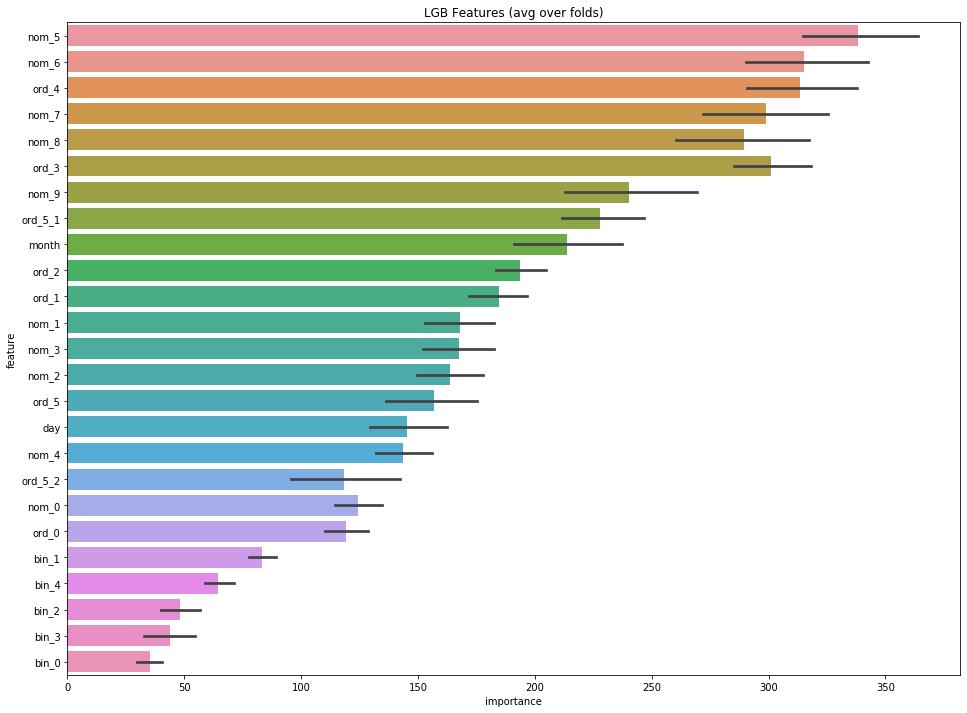

In [193]:
params = {'num_leaves': 48,
          'min_child_samples': 30,
          'objective': 'binary',
          'max_depth': 76,
          'learning_rate': 0.026435924231038266,
          "boosting_type": "gbdt",
          "subsample_freq": 4,
          "subsample": 0.9481868079865589,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
         'reg_alpha': 0.3961060691697725,
        'reg_lambda': 0.47650162280060226, 
         # 'colsample_bytree': 0.5016882736572621,
         # 'feature_fraction': 0.30387207575823505,
          
         }
result_dict_lgb = train_model_classification(X=X, 
                                             X_test=X_test, 
                                             y=y, 
                                             params=params, 
                                             folds=folds,
                                             model_type='lgb',
                                             #model_type='xgb',
                                             eval_metric='auc', 
                                             plot_feature_importance=True,
                                             verbose=500, 
                                             early_stopping_rounds=500, 
                                             n_estimators=8500, 
                                             averaging='usual',
                                             n_jobs=20,
                                                encoder=encoder,
                                                enc_val='double')

In [194]:
test = test.sort_values('id')
test['target'] = result_dict_lgb['prediction']
sub = pd.read_csv('../sub_sample/sample_submission.csv')
sub['target'] = test['target']
sub.to_csv('../sub/DWRZ-15-v05-double-LGB.csv', index=False)
sub.head()

,id,target
0,300000,0.342218779796588
1,300001,0.675568813940124
2,300002,0.154978463057604
3,300003,0.488135475043400
4,300004,0.768731126156370


## na kaggle 0.80375

# XGB - Double Validation + Best encoder

In [196]:
params = {'bagging_fraction': 0.441098870490176,
 'colsample_bytree': 0.5421845299098174,
 'feature_fraction': 0.5575689209589231,
 'gamma': 0.6311382954375835,
 'learning_rate': 0.1474160430215698,
 'max_depth': 6,
 'min_child_samples': 210,
 'num_leaves': 185,
 'reg_alpha': 0.09950080245981832,
 'reg_lambda': 0.13146625357856032,
 'subsample': 0.8
          
         }
result_dict_lgb = train_model_classification(X=X, 
                                             X_test=X_test, 
                                             y=y, 
                                             params=params, 
                                             folds=folds,
                                          
                                           #  model_type='lgb',
                                             model_type='xgb',
                                             #eval_metric='auc', 
                                             plot_feature_importance=True,
                                             #verbose=500, 
                                             early_stopping_rounds=500, 
                                             n_estimators=700, 
                                             averaging='usual',
                                             n_jobs=20,
                                             encoder=encoder,
                                                enc_val='double')

Fold 1 started at Wed Oct 16 21:19:40 2019
[21:21:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:0.483905	valid_data-rmse:0.484428
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[102]	train-rmse:0.391996	valid_data-rmse:0.404672

Fold 2 started at Wed Oct 16 21:22:14 2019
[21:24:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:0.483979	valid_data-rmse:0.484068
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 500 rounds.
Stopping. Best iteration:
[89]	train-rmse:0.393365	valid_data-rmse:0.404487

Fold 3 started at Wed Oct 16 21:24:46 2019
[21:26:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now

In [197]:
test = test.sort_values('id')
test['target'] = result_dict_lgb['prediction']
sub = pd.read_csv('../sub_sample/sample_submission.csv')
sub['target'] = test['target']
sub.to_csv('../sub/DWRZ-15-v06-double-XGB.csv', index=False)
sub.head()

,id,target
0,300000,0.358620813914708
1,300001,0.611107374940600
2,300002,0.198047220706940
3,300003,0.479086071252823
4,300004,0.814747827393668


### kaggle wynik 0.80328

# LogisticRegression

In [208]:
n_fold = 7
folds = TimeSeriesSplit(n_splits=n_fold)
folds = KFold(n_splits=7)
params = {'C':0.1338,
                        'solver':"lbfgs",
                        'tol':0.0003,
                        'max_iter':5000
                       }

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result_dict_lgb = train_model_classification(X=X, 
                                             X_test=X_test, 
                                             y=y, 
                                             params=params, 
                                             folds=folds,
                                          
                                               model=model,
                                             model_type='sklearn',
                                             #eval_metric='auc', 
                                             plot_feature_importance=True,
                                             verbose=500, 
                                             early_stopping_rounds=500, 
                                             #n_estimators=300, 
                                             averaging='usual',
                                          
                                             encoder=encoder,
                                                enc_val='double')

Fold 1 started at Wed Oct 16 21:48:43 2019
Fold 0. auc: 0.6726.

Fold 2 started at Wed Oct 16 21:50:38 2019
Fold 1. auc: 0.6741.

Fold 3 started at Wed Oct 16 21:52:31 2019
Fold 2. auc: 0.6732.

Fold 4 started at Wed Oct 16 21:54:24 2019
Fold 3. auc: 0.6801.

Fold 5 started at Wed Oct 16 21:56:17 2019
Fold 4. auc: 0.6720.

Fold 6 started at Wed Oct 16 21:58:10 2019
Fold 5. auc: 0.6772.

Fold 7 started at Wed Oct 16 22:00:03 2019
Fold 6. auc: 0.6745.

CV mean score: 0.6748, std: 0.0027.


In [209]:
test = test.sort_values('id')
test['target'] = result_dict_lgb['prediction']
sub = pd.read_csv('../sub_sample/sample_submission.csv')
sub['target'] = test['target']
sub.to_csv('../sub/DWRZ-15-LR.csv', index=False)
sub.head()

,id,target
0,300000,0.268059437082735
1,300001,0.718927780791528
2,300002,0.096420217481787
3,300003,0.496125610186989
4,300004,0.835171216126527


## na kaggle 0.80377

# OPTUNA

In [210]:

import numpy as np
import os
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from lightgbm import LGBMClassifier
import optuna

In [211]:

model = Pipeline([
    ('lgbc', LGBMClassifier(
                    metric= 'log_loss',
                    boosting_type = 'gbdt',
                    objective = 'binary',
                    verbosity = -1,
                    #n_estimators=2000,
                    n_jobs=23))])

In [212]:
def objective(trial):    
    
    joblib.dump(study, 'study.pkl')
    lgbc__learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.8)
    lgbc__max_depth = trial.suggest_int('max_depth', 1, 100)
    lgbc__num_leaves = trial.suggest_int('num_leaves', 1, 350)
   # lgbc__min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 2, 120)
    lgbc__feature_fraction = trial.suggest_uniform('feature_fraction', 0.1, 1.0)
    lgbc__subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    lgbc__min_child_samples = trial.suggest_int('min_child_samples', 5, 130)
    lgbc__subsample_freq = trial.suggest_int('subsample_freq', 2, 20)
    lgbc__reg_alpha = trial.suggest_uniform('reg_alpha', 0.1, 0.9)
    lgbc__reg_lambda = trial.suggest_uniform('reg_lambda', 0.1, 0.9)
    lgbc__colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 0.9)                 
   

    params = {
            'lgbc__learning_rate' : lgbc__learning_rate,
            'lgbc__max_depth' : lgbc__max_depth,
            'lgbc__num_leaves' : lgbc__num_leaves,
           # 'lgbc__min_data_in_leaf' : lgbc__min_data_in_leaf,
            'lgbc__feature_fraction' : lgbc__feature_fraction,
            'lgbc__subsample' : lgbc__subsample,
            'lgbc__min_child_samples' : lgbc__min_child_samples,
            'lgbc__subsample_freq' : lgbc__subsample_freq,
            'lgbc__reg_alpha' : lgbc__reg_alpha,
            'lgbc__reg_lambda' : lgbc__reg_lambda,
            'lgbc__colsample_bytree' : lgbc__colsample_bytree
            }
    
    model.set_params(**params)             

    return - np.mean(cross_val_score(model, X, y, cv=7, n_jobs=1))

In [215]:
study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2019-10-16 22:05:12,662] Finished trial#0 resulted in value: -0.7405933349937898. Current best value is -0.7405933349937898 with parameters: {'learning_rate': 0.09494639924594232, 'max_depth': 53, 'num_leaves': 336, 'feature_fraction': 0.3301941893456588, 'subsample': 0.3121085601310543, 'min_child_samples': 48, 'subsample_freq': 6, 'reg_alpha': 0.12897961293878427, 'reg_lambda': 0.5472758191318411, 'colsample_bytree': 0.6297138148925538}.
[I 2019-10-16 22:05:43,454] Finished trial#1 resulted in value: -0.7445266723384296. Current best value is -0.7445266723384296 with parameters: {'learning_rate': 0.16356464590431455, 'max_depth': 97, 'num_leaves': 298, 'feature_fraction': 0.36011109951090026, 'subsample': 0.9398273525832479, 'min_child_samples': 124, 'subsample_freq': 18, 'reg_alpha': 0.31368399357715726, 'reg_lambda': 0.8812272123130536, 'colsample_bytree': 0.8185915035950401}.
[I 2019-10-16 22:06:12,087] Finished trial#2 resulted in value: -0.7081666671805359. Current best value